# 时间

In [1]:
import json
from collections import Counter

# 1. 读取 JSON 文件
with open('emotion_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)   # 假设文件顶层就是一个数组

# 2. 提取所有 time 字段
times = [item['time'] for item in data]

# 3. 统计每个时间出现的次数
counter = Counter(times)

# 4. 输出结果
for t, cnt in counter.items():
    print(f"{t} —— {cnt} 次")


2020-04-06 0:00 —— 2 次
2020-04-06 00:02:00 —— 1 次
2020-04-06 00:04:00 —— 1 次
2020-04-06 00:07:00 —— 1 次
2020-04-06 00:11:00 —— 2 次
2020-04-06 00:12:00 —— 1 次
2020-04-06 00:13:00 —— 1 次
2020-04-06 00:16:00 —— 1 次
2020-04-06 00:20:00 —— 1 次
2020-04-06 00:21:00 —— 1 次
2020-04-06 00:29:00 —— 1 次
2020-04-06 00:30:00 —— 2 次
2020-04-06 00:32:00 —— 1 次
2020-04-06 00:33:00 —— 2 次
2020-04-06 00:37:00 —— 1 次
2020-04-06 00:49:00 —— 1 次
2020-04-06 00:50:00 —— 1 次
2020-04-06 00:55:00 —— 1 次
2020-04-06 00:56:00 —— 1 次
2020-04-06 00:59:00 —— 1 次
2020-04-06 01:01:00 —— 1 次
2020-04-06 01:06:00 —— 1 次
2020-04-06 01:08:00 —— 1 次
2020-04-06 01:12:00 —— 1 次
2020-04-06 01:13:00 —— 2 次
2020-04-06 01:15:00 —— 1 次
2020-04-06 01:17:00 —— 1 次
2020-04-06 01:22:00 —— 1 次
2020-04-06 01:26:00 —— 1 次
2020-04-06 01:27:00 —— 1 次
2020-04-06 01:38:00 —— 2 次
2020-04-06 01:39:00 —— 2 次
2020-04-06 01:40:00 —— 1 次
2020-04-06 01:48:00 —— 1 次
2020-04-06 01:58:00 —— 1 次
2020-04-06 02:03:00 —— 1 次
2020-04-06 02:07:00 —— 1 次
2020-

In [2]:
import json
from collections import Counter

def aggregate_times(input_path: str, output_path: str):
    # 1. 读取原始数据
    with open(input_path, 'r', encoding='utf-8') as f:
        data = json.load(f)   # 假设最外层就是一个数组

    # 2. 统计 time 字段出现的次数
    counts = Counter(item['time'] for item in data)

    # 3. 构造输出结构
    #    - 按时间排序（可选）
    #    - 把每个 (time, count) 转为 { time: count }
    all_array = [{time: cnt} for time, cnt in sorted(counts.items())]

    output = [
        {
            "All": all_array
        }
    ]

    # 4. 写入 output_path
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(output, f, ensure_ascii=False, indent=2)

if __name__ == '__main__':
    aggregate_times('emotion_data.json', 'time_count.json')
    print("output.json 已生成，包含统计结果。")


output.json 已生成，包含统计结果。


# 词graph

In [2]:
! pip install nltk

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached regex-2024.11.6-cp312-cp312-win_amd64.whl.metadata (41 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached regex-2024.11.6-cp312-cp312-win_amd64.whl (273 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tslearn 0.6.3 requires numba, which is not installed.
tslearn 0.6.3 requires scikit-learn, which is not installed.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import json
import itertools
from collections import Counter, defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

def main():
    # —— 1. 加载数据并过滤掉不需要的用户 —— 
    INPUT_FILE = './emotion_data.json'
    OUTPUT_FILE = 'word_graph.json'

    ignore_accounts = [
        'Syndicated4',
        '______3333_____',
        'Syndicated348',
        'CantonCoordon2',
        'Syndicated5',
        'Opportunities2',
        'JordanWantsBac0n',
        'Opportunities1',
        'J0rdanWantsBacon',
        'handle'
    ]

    # —— 2. 初始化 NLTK 分词、停用词与 POS tagger —— 
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')

    # 默认英文停用词
    stop_words = set(stopwords.words('english'))

    # 你的 extra_stopwords（保持不变）
    extra_stopwords = [
        # 常见动词（示例）
        'get', 'got', 'make', 'makes', 'making', 'go', 'goes', 'going',
        'come', 'comes', 'coming', 'take', 'takes', 'taking',
        'see', 'sees', 'seeing', 'use', 'uses', 'using',
        'want', 'wants', 'wanting', 'like', 'likes', 'liking',
        'know', 'knows', 'knowing', 'think', 'thinks', 'thinking',
        'need', 'needs', 'needed', 'look', 'looks', 'looking',
        'show', 'shows', 'showing', 'say', 'says', 'saying',
        'someone', 'something', 'anyone', 'anything', 'one',

        # 代词
        'i', 'me', 'my', 'mine', 'you', 'your', 'yours',
        'he', 'him', 'his', 'she', 'her', 'hers',
        'it', 'its', 'we', 'us', 'our', 'ours',
        'they', 'them', 'their', 'theirs', 'this', 'that',
        'these', 'those', 'himself', 'herself', 'itself',
        'ourselves', 'yourselves', 'themselves',

        # 情态动词 & 助动词
        'will', 'would', 'shall', 'should', 'can', 'could',
        'may', 'might', 'must', 'ought',
        'am', 'is', 'are', 'was', 'were', 'be', 'being', 'been',
        'do', 'does', 'did', 'have', 'has', 'had',

        # 连词
        'and', 'but', 'if', 'or', 'because', 'as', 'until',
        'while', 'where', 'when', 'than', 'though', 'although',

        # 介词
        'in', 'on', 'at', 'for', 'with', 'about', 'against',
        'between', 'into', 'through', 'during', 'before',
        'after', 'above', 'below', 'to', 'from', 'up', 'down',
        'over', 'under', 'again', 'further',

        # 常用形容词/副词
        'good', 'new', 'first', 'last', 'long', 'great',
        'little', 'own', 'other', 'old', 'right', 'big',
        'high', 'different', 'small', 'large', 'next',
        'early', 'young', 'important', 'few', 'public',
        'bad', 'same', 'able',
        'very', 'really', 'actually', 'just', 'even', 'still', 'only',
        'also', 'ever', 'never', 'always', 'usually', 'often', 'sometimes',
        'well', 'here', 'there', 'now', 'then', 'today', 'tomorrow', 'yesterday',
        'people','much','many','find','back','best','good','better','please','around','everyone','heard',

        # 其它社媒填充词
        'rt', 'dm', 'pm',
    ]
    stop_words |= set(extra_stopwords)

    # —— 3. 读取 JSON 并过滤账号 —— 
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        data = json.load(f)
    filtered = [msg for msg in data if msg.get('account') not in ignore_accounts]

    # —— 4. 分词→去停用词→POS→去形容词/副词/介词/连词/情态/助动 →统计 —— 
    total_freq = Counter()
    cooc_counts = defaultdict(int)
    word2msgs = defaultdict(set)

    for msg in filtered:
        idx = msg.get('index')
        text = msg.get('message_words', '')

        # 4.1 分词 & 基本清洗
        tokens_raw = word_tokenize(text)
        tokens = [t.lower() for t in tokens_raw if t.isalpha() and t.lower() not in stop_words]
        if not tokens:
            continue

        # 4.2 POS 标注，过滤 JJ*, RB*, IN, CC, MD, TO
        tagged = pos_tag(tokens)
        tokens = [
            w for w, tag in tagged
            if not (
                tag.startswith('JJ')   # 形容词
                or tag.startswith('RB')# 副词
                or tag in {'IN','CC','MD','TO'}  # 介词/连词/情态/助动/不定式标记
            )
        ]
        if not tokens:
            continue

        # 4.3 更新统计
        total_freq.update(tokens)
        for w in set(tokens):
            word2msgs[w].add(idx)
        for w1, w2 in itertools.combinations(sorted(set(tokens)), 2):
            cooc_counts[(w1, w2)] += 1

    # —— 5. 构建 Graph 并输出 JSON —— 
    words = sorted(total_freq, key=lambda w: (-total_freq[w], w))
    word2idx = {w: i+1 for i, w in enumerate(words)}

    nodes = [
        {'index': word2idx[w], 'word': w, 'messages': sorted(word2msgs[w])}
        for w in words
    ]
    links = [
        {'source': word2idx[w1], 'target': word2idx[w2], 'weight': cnt}
        for (w1, w2), cnt in cooc_counts.items() if cnt > 0
    ]

    graph = {'nodes': nodes, 'links': links}
    with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
        json.dump(graph, f, ensure_ascii=False, indent=2)

    print(f'完成！生成 {OUTPUT_FILE}：{len(nodes)} 个节点，{len(links)} 条边。')

if __name__ == '__main__':
    main()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


完成！生成 word_graph.json：11528 个节点，116397 条边。


In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import json
import itertools
from collections import Counter, defaultdict

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

def pos_to_wordnet(tag):
    """把 NLTK 的 POS tag 映射到 wordnet 的 POS 类别"""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def main():
    # —— 1. 加载 & 过滤账号 —— 
    INPUT_FILE = './emotion_data.json'
    OUTPUT_FILE = 'word_graph.json'
    ignore_accounts = [
        'Syndicated4','______3333_____','Syndicated348','CantonCoordon2',
        'Syndicated5','Opportunities2','JordanWantsBac0n',
        'Opportunities1','J0rdanWantsBacon','handle'
    ]

    # —— 2. 初始化 NLTK 资源 & 停用词 —— 
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

    # 只用 NLTK 默认停用词做第一轮清洗
    base_stop_words = set(stopwords.words('english'))

    # 你的自定义停用词列表（保持原样，不要删！）
    extra_stopwords = [
        'get','got','make','makes','making','go','goes','going',
        'come','comes','coming','take','takes','taking',
        'see','sees','seeing','use','uses','using',
        'want','wants','wanting','like','likes','liking',
        'know','knows','knowing','think','thinks','thinking',
        'need','needs','needed','look','looks','looking',
        'show','shows','showing','say','says','saying',
        'someone','something','anyone','anything','one',
        'i','me','my','mine','you','your','yours','he','him','his',
        'she','her','hers','it','its','we','us','our','ours',
        'they','them','their','theirs','this','that','these','those',
        'himself','herself','itself','ourselves','yourselves','themselves',
        'will','would','shall','should','can','could','may','might',
        'must','ought','am','is','are','was','were','be','being','been',
        'do','does','did','have','has','had',
        'and','but','if','or','because','as','until','while','where',
        'when','than','though','although',
        'in','on','at','for','with','about','against','between','into',
        'through','during','before','after','above','below','to','from',
        'up','down','over','under','again','further',
        'good','new','first','last','long','great','little','own','other',
        'old','right','big','high','different','small','large','next',
        'early','young','important','few','public','bad','same','able',
        'very','really','actually','just','even','still','only','also',
        'ever','never','always','usually','often','sometimes','well',
        'here','there','now','then','today','tomorrow','yesterday',
        'people','much','many','find','back','best','better','please',
        'around','everyone','heard','lot','call','say','rt','dm','pm'
    ]
    extra_stop_set = set(extra_stopwords)

    lemmatizer = WordNetLemmatizer()

    # —— 3. 读取 JSON 并过滤账号 —— 
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        data = json.load(f)
    filtered = [m for m in data if m.get('account') not in ignore_accounts]

    # —— 4. 分词→第一次停用词→POS→词形还原→第二次停用词→统计 —— 
    total_freq   = Counter()
    cooc_counts  = defaultdict(int)
    word2msgs    = defaultdict(set)

    for msg in filtered:
        idx = msg['index']
        text = msg.get('message_words','')

        # 分词 & 去基础停用词
        tokens0 = word_tokenize(text)
        tokens  = [t.lower() for t in tokens0
                   if t.isalpha() and t.lower() not in base_stop_words]
        if not tokens:
            continue

        # POS 标注
        tagged = pos_tag(tokens)
        kept   = []
        for w, tag in tagged:
            # 先过滤不用的 POS 类别
            if (tag.startswith('JJ') or tag.startswith('RB')
                or tag in {'IN','CC','TO','MD'}):
                continue

            # 词形还原
            wn_tag = pos_to_wordnet(tag)
            if wn_tag:
                w_lemma = lemmatizer.lemmatize(w, wn_tag)
            else:
                w_lemma = lemmatizer.lemmatize(w)

            # **在这里** 再过滤你的自定义 stopwords，防止各种形式漏掉
            if w_lemma in extra_stop_set:
                continue

            kept.append(w_lemma)

        if not kept:
            continue

        # 更新词频、共现、消息索引
        total_freq.update(kept)
        for w in set(kept):
            word2msgs[w].add(idx)
        for w1, w2 in itertools.combinations(sorted(set(kept)), 2):
            cooc_counts[(w1, w2)] += 1

    # —— 5. 输出 Graph JSON —— 
    words    = sorted(total_freq, key=lambda w: (-total_freq[w], w))
    word2idx = {w: i+1 for i, w in enumerate(words)}

    nodes = [{'index': word2idx[w], 'word': w, 'messages': sorted(word2msgs[w])}
             for w in words]
    links = [{'source': word2idx[w1], 'target': word2idx[w2], 'weight': cnt}
             for (w1, w2), cnt in cooc_counts.items() if cnt > 0]

    with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
        json.dump({'nodes': nodes, 'links': links}, f,
                  ensure_ascii=False, indent=2)

    print(f'完成！共 {len(nodes)} 个节点，{len(links)} 条边，输出到 {OUTPUT_FILE}')

if __name__ == '__main__':
    main()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


完成！共 9586 个节点，104470 条边，输出到 word_graph.json


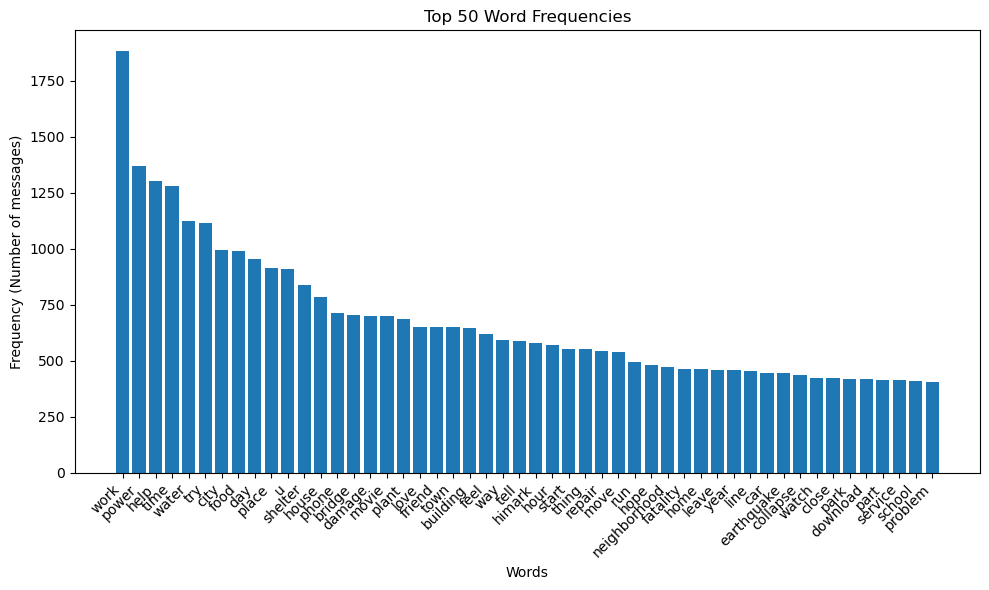

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import json
import matplotlib.pyplot as plt

def main():
    # 1. 读取 graph JSON
    INPUT_FILE = 'word_graph.json'
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        graph = json.load(f)

    # 2. 计算每个词的“频次”（messages 列表长度）
    freqs = [(node['word'], len(node['messages'])) for node in graph['nodes']]

    # 3. 按频次降序排序，取前 top_n
    freqs_sorted = sorted(freqs, key=lambda x: x[1], reverse=True)
    top_n = 50  # 要显示的词数，可自行调整
    top_words, top_counts = zip(*freqs_sorted[:top_n])

    # 4. 绘制柱状图
    plt.figure(figsize=(10, 6))
    plt.bar(top_words, top_counts)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Frequency (Number of messages)')
    plt.title(f'Top {top_n} Word Frequencies')
    plt.tight_layout()

    # 5. 显示图形
    plt.show()

if __name__ == '__main__':
    main()


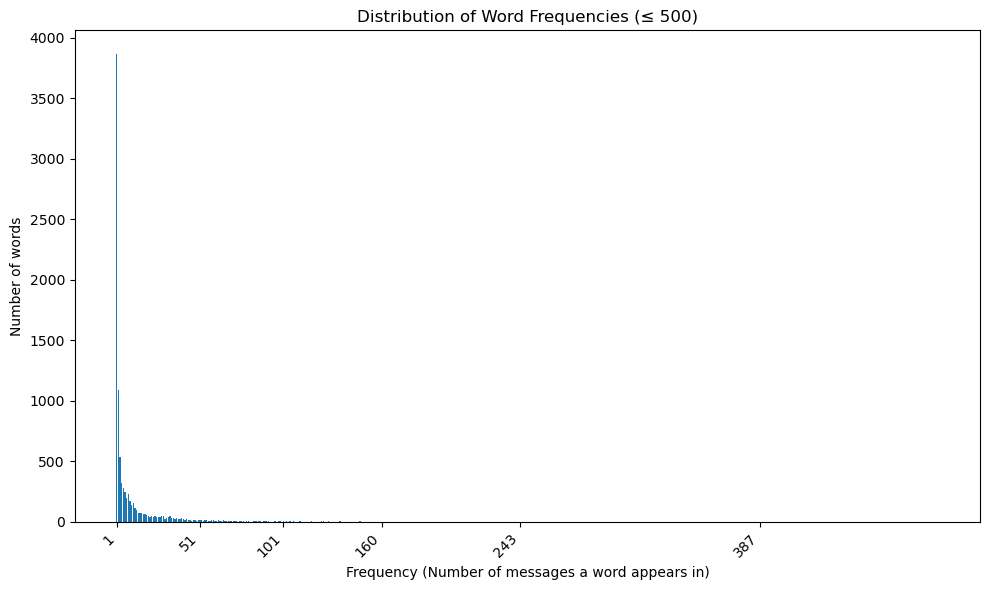

In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import json
from collections import Counter
import matplotlib.pyplot as plt

def main():
    # 1. 读取 graph JSON
    INPUT_FILE = 'word_graph.json'
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        graph = json.load(f)

    # 2. 计算每个词的“频次”（messages 列表长度）
    freqs = [len(node['messages']) for node in graph['nodes']]

    # 3. 统计每个“频次”出现了多少个词
    dist = Counter(freqs)  # dist[f] = 出现 f 次的词有多少个

    # 4. 只保留频次 ≤ 500
    freq_values = [f for f in sorted(dist) if f <= 500]
    word_counts  = [dist[f] for f in freq_values]

    # 5. 绘制分布柱状图
    plt.figure(figsize=(10, 6))
    plt.bar(freq_values, word_counts)
    plt.xticks(freq_values[::50], rotation=45, ha='right')  # 每隔50个频次打一个标签，避免拥挤
    plt.xlabel('Frequency (Number of messages a word appears in)')
    plt.ylabel('Number of words')
    plt.title('Distribution of Word Frequencies (≤ 500)')
    plt.tight_layout()

    # 6. 显示图形
    plt.show()

if __name__ == '__main__':
    main()


In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import json
import itertools
from collections import Counter, defaultdict

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

def pos_to_wordnet(tag):
    """把 NLTK 的 POS tag 映射到 wordnet 的 POS 类别"""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def main():
    # —— 参数区 —— 
    INPUT_FILE  = './emotion_data.json'
    OUTPUT_FILE = 'word_graph.json'
    MIN_FREQ    = 5        # 只保留出现次数 > MIN_FREQ 的词

    ignore_accounts = [
        'Syndicated4','______3333_____','Syndicated348','CantonCoordon2',
        'Syndicated5','Opportunities2','JordanWantsBac0n',
        'Opportunities1','J0rdanWantsBacon','handle'
    ]

    # —— 初始化 NLTK 资源 & 停用词 —— 
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

    base_stop_words = set(stopwords.words('english'))

    extra_stopwords = [
        # （这里保持你原来的列表不动……）
        'get','got','make','makes','making','go','goes','going',
        'come','comes','coming','take','takes','taking',
        'see','sees','seeing','use','uses','using',
        'want','wants','wanting','like','likes','liking',
        'know','knows','knowing','think','thinks','thinking',
        'need','needs','needed','look','looks','looking',
        'show','shows','showing','say','says','saying',
        'someone','something','anyone','anything','one',
        'i','me','my','mine','you','your','yours','he','him','his',
        'she','her','hers','it','its','we','us','our','ours',
        'they','them','their','theirs','this','that','these','those',
        'himself','herself','itself','ourselves','yourselves','themselves',
        'will','would','shall','should','can','could','may','might',
        'must','ought','am','is','are','was','were','be','being','been',
        'do','does','did','have','has','had',
        'and','but','if','or','because','as','until','while','where',
        'when','than','though','although',
        'in','on','at','for','with','about','against','between','into',
        'through','during','before','after','above','below','to','from',
        'up','down','over','under','again','further',
        'good','new','first','last','long','great','little','own','other',
        'old','right','big','high','different','small','large','next',
        'early','young','important','few','public','bad','same','able',
        'very','really','actually','just','even','still','only','also',
        'ever','never','always','usually','often','sometimes','well',
        'here','there','now','then','today','tomorrow','yesterday',
        'people','much','many','find','back','best','better','please',
        'around','everyone','heard','lot','call','say','rt','dm','pm'
    ]
    extra_stop_set = set(extra_stopwords)

    lemmatizer = WordNetLemmatizer()

    # —— 读取并过滤账号 —— 
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        data = json.load(f)
    filtered = [m for m in data if m.get('account') not in ignore_accounts]

    # —— 分词→停用词→POS→词形还原→二次停用词→统计 —— 
    total_freq   = Counter()
    cooc_counts  = defaultdict(int)
    word2msgs    = defaultdict(set)

    for msg in filtered:
        idx   = msg['index']
        text  = msg.get('message_words','')
        # 第一次清洗
        tokens0 = word_tokenize(text)
        tokens  = [t.lower() for t in tokens0
                   if t.isalpha() and t.lower() not in base_stop_words]
        if not tokens:
            continue

        # POS & Lemmatization
        tagged = pos_tag(tokens)
        kept   = []
        for w, tag in tagged:
            if tag.startswith('JJ') or tag.startswith('RB') or tag in {'IN','CC','TO','MD'}:
                continue
            wn_tag = pos_to_wordnet(tag)
            lemma = (lemmatizer.lemmatize(w, wn_tag)
                     if wn_tag else lemmatizer.lemmatize(w))
            # 第二次自定义停用词过滤
            if lemma in extra_stop_set:
                continue
            kept.append(lemma)

        if not kept:
            continue

        # 统计
        total_freq.update(kept)
        for w in set(kept):
            word2msgs[w].add(idx)
        for w1, w2 in itertools.combinations(sorted(set(kept)), 2):
            cooc_counts[(w1, w2)] += 1

    # —— 构建 Graph，去掉低频词（<=MIN_FREQ） —— 
    # 只保留 freq > MIN_FREQ 的词
    high_freq_words = {w for w, cnt in total_freq.items() if cnt > MIN_FREQ}
    # 排序并编号
    words    = sorted(high_freq_words, key=lambda w: (-total_freq[w], w))
    word2idx = {w: i+1 for i, w in enumerate(words)}

    # 构造 nodes
    nodes = [
        {'index': word2idx[w], 'word': w, 'messages': sorted(word2msgs[w])}
        for w in words
    ]
    # 构造 links，仅当两个词都在 high_freq_words 中才保留
    links = [
        {'source': word2idx[w1], 'target': word2idx[w2], 'weight': cnt}
        for (w1, w2), cnt in cooc_counts.items()
        if w1 in high_freq_words and w2 in high_freq_words
    ]

    # 输出
    with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
        json.dump({'nodes': nodes, 'links': links}, f,
                  ensure_ascii=False, indent=2)

    print(f'完成！共 {len(nodes)} 个节点，{len(links)} 条边，输出到 {OUTPUT_FILE}')

if __name__ == '__main__':
    main()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


完成！共 3519 个节点，64361 条边，输出到 word_graph.json


## 按激烈程度

In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import json
import itertools
from collections import Counter, defaultdict

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

def pos_to_wordnet(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def main():
    INPUT_FILE   = './emotion_data.json'
    OUTPUT_FILE  = 'word_graph1.json'
    ignore_accounts = [
        'Syndicated4','______3333_____','Syndicated348','CantonCoordon2',
        'Syndicated5','Opportunities2','JordanWantsBac0n',
        'Opportunities1','J0rdanWantsBacon','handle'
    ]

    # 下载并初始化
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

    base_stop = set(stopwords.words('english'))
    extra_stopwords = [
        # （保持你现有的停用词列表不动）
        'get','got','make','makes','making','go','goes','going',
        'come','comes','coming','take','takes','taking',
        'see','sees','seeing','use','uses','using',
        'want','wants','wanting','like','likes','liking',
        'know','knows','knowing','think','thinks','thinking',
        'need','needs','needed','look','looks','looking',
        'show','shows','showing','say','says','saying',
        'someone','something','anyone','anything','one',
        'i','me','my','mine','you','your','yours','he','him','his',
        'she','her','hers','it','its','we','us','our','ours',
        'they','them','their','theirs','this','that','these','those',
        'himself','herself','itself','ourselves','yourselves','themselves',
        'will','would','shall','should','can','could','may','might',
        'must','ought','am','is','are','was','were','be','being','been',
        'do','does','did','have','has','had',
        'and','but','if','or','because','as','until','while','where',
        'when','than','though','although',
        'in','on','at','for','with','about','against','between','into',
        'through','during','before','after','above','below','to','from',
        'up','down','over','under','again','further',
        'good','new','first','last','long','great','little','own','other',
        'old','right','big','high','different','small','large','next',
        'early','young','important','few','public','bad','same','able',
        'very','really','actually','just','even','still','only','also',
        'ever','never','always','usually','often','sometimes','well',
        'here','there','now','then','today','tomorrow','yesterday',
        'people','much','many','find','back','best','better','please',
        'around','everyone','heard','lot','call','say','rt','dm','pm'
    ]
    extra_stop = set(extra_stopwords)

    lemmatizer = WordNetLemmatizer()

    # 读取并过滤账号
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        data = json.load(f)
    filtered = [m for m in data if m.get('account') not in ignore_accounts]

    # 准备容器
    total_cooc = defaultdict(int)
    word_msgs  = defaultdict(set)
    word_score = defaultdict(float)

    for msg in filtered:
        idx     = msg['index']
        emotion = msg.get('emotion', 0.0)
        dist    = abs(emotion - 0.5)

        # 分词 + 第一轮停用词
        tokens0 = word_tokenize(msg.get('message_words',''))
        tokens  = [t.lower() for t in tokens0 if t.isalpha() and t.lower() not in base_stop]
        if not tokens:
            continue

        # POS + Lemmatization + 第二轮自定义停用词
        tagged = pos_tag(tokens)
        kept   = []
        for w, tag in tagged:
            if tag.startswith('JJ') or tag.startswith('RB') or tag in {'IN','CC','TO','MD'}:
                continue
            wn = pos_to_wordnet(tag)
            lemma = lemmatizer.lemmatize(w, wn) if wn else lemmatizer.lemmatize(w)
            if lemma in extra_stop:
                continue
            kept.append(lemma)

        if not kept:
            continue

        # 更新共现 & 出现消息索引
        for w1, w2 in itertools.combinations(sorted(set(kept)), 2):
            total_cooc[(w1, w2)] += 1
        for w in set(kept):
            word_msgs[w].add(idx)
            word_score[w] += dist

    # 构建 nodes & links（不过滤低频，全部输出）
    words = sorted(word_score, key=lambda w: (-word_score[w], w))
    word2idx = {w: i+1 for i, w in enumerate(words)}

    nodes = []
    for w in words:
        nodes.append({
            'index':    word2idx[w],
            'word':     w,
            'score':    round(word_score[w], 6),
            'messages': sorted(word_msgs[w])
        })

    links = []
    for (w1, w2), cnt in total_cooc.items():
        if w1 in word2idx and w2 in word2idx:
            links.append({
                'source': word2idx[w1],
                'target': word2idx[w2],
                'weight': cnt
            })

    out = {'nodes': nodes, 'links': links}
    with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
        json.dump(out, f, ensure_ascii=False, indent=2)

    print(f'已生成 {OUTPUT_FILE}，共 {len(nodes)} 个节点，{len(links)} 条边。')

if __name__ == '__main__':
    main()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


已生成 word_graph1.json，共 9586 个节点，104470 条边。


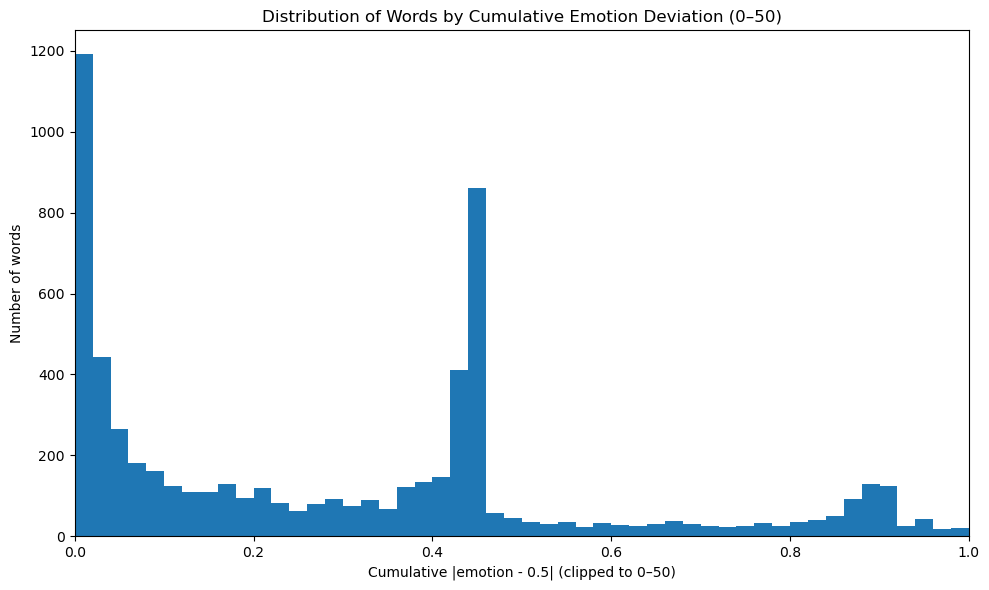

In [24]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import json
import matplotlib.pyplot as plt

def main():
    INPUT_FILE = 'word_graph1.json'
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        graph = json.load(f)

    # 取出所有词的累计 emotion 距离分数
    scores = [node['score'] for node in graph['nodes']]

    # 只看 0 到 50 范围
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=50, range=(0, 1))
    plt.xlim(0, 1)
    plt.xlabel('Cumulative |emotion - 0.5| (clipped to 0–50)')
    plt.ylabel('Number of words')
    plt.title('Distribution of Words by Cumulative Emotion Deviation (0–50)')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


In [26]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import json

def main():
    INPUT_FILE  = 'word_graph1.json'
    OUTPUT_FILE = 'word_graph1.json'
    THRESHOLD   = 0.5

    # 1. 读取 word_graph1.json
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        data = json.load(f)
    nodes = data['nodes']
    links = data['links']

    # 2. 筛选出 score > THRESHOLD 的节点
    kept_nodes = [n for n in nodes if n.get('score', 0) > THRESHOLD]

    # 3. 构建老索引 -> 新索引 的映射
    old2new = {}
    for new_idx, node in enumerate(kept_nodes, start=1):
        old2new[node['index']] = new_idx

    # 4. 重新生成 nodes，使用新索引
    new_nodes = []
    for node in kept_nodes:
        new_nodes.append({
            'index':    old2new[node['index']],
            'word':     node['word'],
            'score':    node['score'],
            'messages': node['messages']
        })

    # 5. 筛选 links：只有当两个端点都在 kept_nodes 中才保留
    new_links = []
    for link in links:
        s_old = link['source']
        t_old = link['target']
        if s_old in old2new and t_old in old2new:
            new_links.append({
                'source': old2new[s_old],
                'target': old2new[t_old],
                'weight': link['weight']
            })

    # 6. 覆盖写入 word_graph.json
    with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
        json.dump({'nodes': new_nodes, 'links': new_links}, f,
                  ensure_ascii=False, indent=2)

    print(f'过滤完成：保留 {len(new_nodes)} 个节点，{len(new_links)} 条边，结果已写入 {OUTPUT_FILE}')

if __name__ == '__main__':
    main()


过滤完成：保留 4334 个节点，71313 条边，结果已写入 word_graph1.json


## 统计差异

In [27]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import json

def load_words(filename):
    """从指定的 graph JSON 文件读取所有节点的 word 字段，返回一个 set"""
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return { node['word'] for node in data.get('nodes', []) }

def main():
    # 文件名
    FILE1 = 'word_graph.json'
    FILE2 = 'word_graph1.json'

    # 加载两个图的词集合
    words1 = load_words(FILE1)
    words2 = load_words(FILE2)

    # 计算交集和差集
    intersect = words1 & words2
    only_in_1 = words1 - words2
    only_in_2 = words2 - words1

    # 打印结果
    print(f'共计 word_graph 中节点数：{len(words1)}')
    print(f'共计 word_graph1 中节点数：{len(words2)}\n')

    print(f'两者都包含的节点数（交集）：{len(intersect)}')
    print(f'仅在 word_graph 中但不在 word_graph1 的节点数：{len(only_in_1)}')
    print(f'仅在 word_graph1 中但不在 word_graph 的节点数：{len(only_in_2)}\n')

    # 如果需要可以打印出具体的词列表，例如：
    # print('仅在 word_graph 中的词：', sorted(only_in_1))
    # print('仅在 word_graph1 中的词：', sorted(only_in_2))

if __name__ == '__main__':
    main()


共计 word_graph 中节点数：3519
共计 word_graph1 中节点数：4334

两者都包含的节点数（交集）：3060
仅在 word_graph 中但不在 word_graph1 的节点数：459
仅在 word_graph1 中但不在 word_graph 的节点数：1274



输出一些例子看看是否有必要保留

In [30]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import json

def main():
    # 文件路径
    FILE_GRAPH   = 'word_graph.json'
    FILE_GRAPH1  = 'word_graph1.json'
    TOP_N        = 50

    # 1. 读取两个图的数据
    with open(FILE_GRAPH,  'r', encoding='utf-8') as f:
        data0 = json.load(f)
    with open(FILE_GRAPH1, 'r', encoding='utf-8') as f:
        data1 = json.load(f)

    # 2. 构造两个图的词集合
    words0 = {node['word'] for node in data0['nodes']}
    words1 = {node['word'] for node in data1['nodes']}

    # -- 部分一：word_graph1 中独有的，按 score 排序 --
    unique1 = [node for node in data1['nodes'] if node['word'] not in words0]
    top50_score = sorted(unique1,
                         key=lambda x: x.get('score', 0),
                         reverse=True)[:TOP_N]

    print(f"Top {TOP_N} words in word_graph1 but not in word_graph, by score:")
    for node in top50_score:
        print(f"{node['word']}: {node.get('score', 0):.6f}")
    print()

    # -- 部分二：word_graph 中独有的，按 frequency 排序 --
    unique0 = [node for node in data0['nodes'] if node['word'] not in words1]
    # 频次定义为 messages 列表长度
    top50_freq = sorted(unique0,
                        key=lambda x: len(x.get('messages', [])),
                        reverse=True)[:TOP_N]

    print(f"Top {TOP_N} words in word_graph but not in word_graph1, by frequency:")
    for node in top50_freq:
        freq = len(node.get('messages', []))
        print(f"{node['word']}: {freq}")

if __name__ == '__main__':
    main()


Top 50 words in word_graph1 but not in word_graph, by score:
inheritance: 2.268705
hummus: 2.258073
patriot: 2.255651
suggestion: 2.247961
meaningless: 2.244059
evince: 2.242954
measles: 2.234888
getghes: 2.234402
attentive: 2.231427
varseals: 2.230012
baddd: 2.226222
faint: 2.226222
fustilarians: 2.224954
lying: 2.223939
democrat: 2.222408
meltdown: 2.222262
spongy: 2.221256
iíd: 2.217968
puny: 2.216030
sank: 2.215118
faith: 2.213044
sleet: 2.205432
collecting: 2.200386
forwarseard: 2.197321
saucy: 2.194574
dewberry: 2.184067
moron: 2.181898
girrrl: 2.178544
calf: 2.178258
courtesy: 2.178258
con: 2.173170
fawn: 2.170148
madhouse: 2.148974
gloat: 2.138788
mansion: 2.138788
orchestrate: 2.138788
wil: 2.138788
supplement: 2.136884
enough: 2.135981
pillow: 2.131868
weldome: 2.131868
caliukem: 2.104986
midterm: 2.104986
waitress: 2.099607
artists: 2.051487
hot: 2.034626
dread: 2.033575
gorbellied: 2.024047
devekioubg: 2.011301
rists: 2.011301

Top 50 words in word_graph but not in word_gra

In [33]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import json
import itertools

import nltk
from nltk.tokenize import word_tokenize

def main():
    # —— 参数区 —— 
    CNT_FILE      = 'word_graph_cnt.json'
    EMO_FILE      = 'word_graph_emotion.json'
    DATA_FILE     = 'emotion_data.json'
    OUTPUT_FILE   = 'word_graph_union.json'

    # —— 1. 读取两个已有图的节点，取并集 —— 
    with open(CNT_FILE, 'r', encoding='utf-8') as f:
        cnt = json.load(f)
    with open(EMO_FILE, 'r', encoding='utf-8') as f:
        emo = json.load(f)

    # word -> set(messages)
    union_msgs = {}
    for node in cnt['nodes'] + emo['nodes']:
        w = node['word']
        msgs = set(node.get('messages', []))
        union_msgs.setdefault(w, set()).update(msgs)

    # 所有词并集
    words = sorted(union_msgs.keys())

    # —— 2. 准备 NLTK —— 
    nltk.download('punkt')

    # —— 3. 载入原始 emotion_data，用于重算共现边 —— 
    with open(DATA_FILE, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 构建消息索引到词的映射：msg_idx -> set(words in union)
    msg_to_words = {}
    for msg in data:
        idx = msg.get('index')
        text = msg.get('message_words', '')
        tokens = word_tokenize(text)
        toks = {t.lower() for t in tokens if t.isalpha()}
        # 取交集，只保留并集中出现的词
        ws = toks & set(words)
        if ws:
            msg_to_words[idx] = ws

    # —— 4. 统计共现关系 —— 
    cooc = {}
    for ws in msg_to_words.values():
        for w1, w2 in itertools.combinations(sorted(ws), 2):
            cooc[(w1, w2)] = cooc.get((w1, w2), 0) + 1

    # —— 5. 构建输出节点与边 —— 
    # 重新编号
    word2idx = {w: i+1 for i, w in enumerate(words)}

    nodes = [
        {'index': word2idx[w], 'word': w, 'messages': sorted(union_msgs[w])}
        for w in words
    ]

    links = [
        {'source': word2idx[w1], 'target': word2idx[w2], 'weight': cnt}
        for (w1, w2), cnt in cooc.items() if cnt > 0
    ]

    # —— 6. 写出新图 —— 
    out = {'nodes': nodes, 'links': links}
    with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
        json.dump(out, f, ensure_ascii=False, indent=2)

    print(f"Done: {len(nodes)} nodes and {len(links)} links written to {OUTPUT_FILE}")

if __name__ == '__main__':
    main()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\35049\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Done: 4793 nodes and 61700 links written to word_graph_union.json


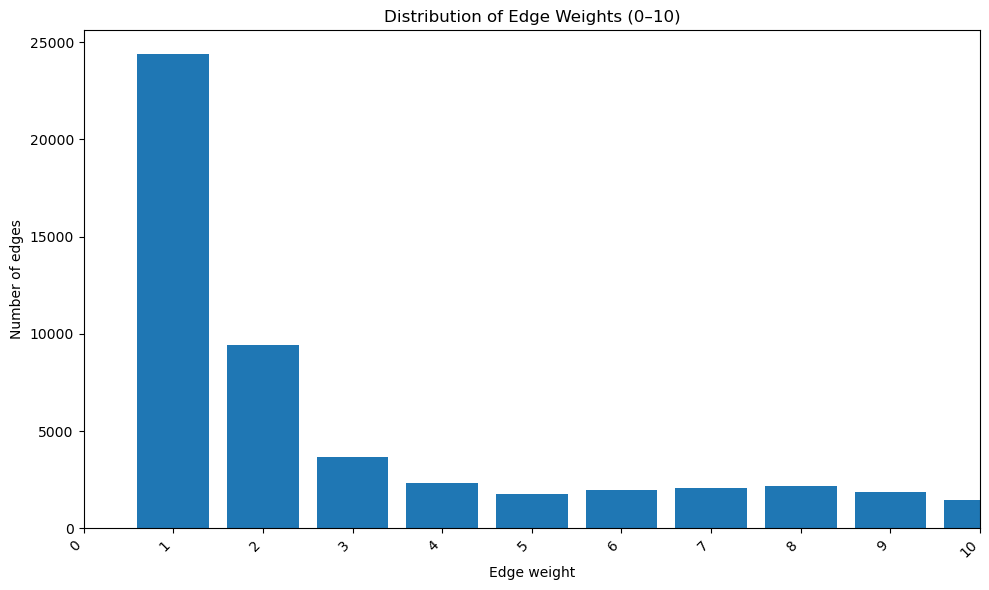

In [34]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import json
from collections import Counter
import matplotlib.pyplot as plt

def main():
    # 1. 读取合并后的图 JSON
    INPUT_FILE = 'word_graph_union.json'
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        graph = json.load(f)

    # 2. 提取所有边的 weight
    weights = [link['weight'] for link in graph.get('links', [])]

    # 3. 统计每个 weight 出现的次数
    dist = Counter(weights)

    # 4. 只保留 weight 在 0–10 范围内
    weight_values = [w for w in sorted(dist) if 0 <= w <= 10]
    edge_counts   = [dist[w] for w in weight_values]

    # 5. 绘制分布柱状图
    plt.figure(figsize=(10, 6))
    plt.bar(weight_values, edge_counts)
    plt.xlim(0, 10)
    plt.xticks(range(0, 11), rotation=45, ha='right')
    plt.xlabel('Edge weight')
    plt.ylabel('Number of edges')
    plt.title('Distribution of Edge Weights (0–10)')
    plt.tight_layout()

    # 6. 显示
    plt.show()

if __name__ == '__main__':
    main()


In [35]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import json

def main():
    INPUT_FILE  = 'word_graph_union.json'
    OUTPUT_FILE = 'word_graph_union.json'  # 覆盖写回

    # 1. 读取现有图
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        graph = json.load(f)

    # 2. 只保留 weight > 2 的边
    filtered_links = [link for link in graph.get('links', []) if link.get('weight', 0) > 2]

    # 3. 可选：如果你希望剔除所有已无边连接的孤立节点，取消下面两行注释
    # linked_indices = {link['source'] for link in filtered_links} | {link['target'] for link in filtered_links}
    # graph['nodes'] = [node for node in graph.get('nodes', []) if node['index'] in linked_indices]

    # 4. 更新 links 并写回 JSON
    graph['links'] = filtered_links
    with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
        json.dump(graph, f, ensure_ascii=False, indent=2)

    print(f'过滤完成，保留了 {len(filtered_links)} 条 weight>2 的边，结果已覆盖写入 {OUTPUT_FILE}')

if __name__ == '__main__':
    main()


过滤完成，保留了 27876 条 weight>2 的边，结果已覆盖写入 word_graph_union.json


## 加资源

In [ ]:
import json
from collections import defaultdict

# 读取 emotion_data.json 文件
with open('emotion_data.json', 'r', encoding='utf-8') as f:
    emotion_data = json.load(f)

# 读取 word_graph_union.json 文件
with open('word_graph_union.json', 'r', encoding='utf-8') as f:
    word_graph_data = json.load(f)

# 假设你要添加的词汇列表
new_words = ["nuclear"]

# 获取现有的节点和消息
existing_nodes = word_graph_data["nodes"]
existing_links = word_graph_data["links"]
messages = emotion_data

# 新的词汇的节点索引
new_index_start = len(existing_nodes) + 1  # 新节点的起始索引

# 找到包含新词的消息
word_to_messages = defaultdict(list)
for i, word in enumerate(new_words):
    for msg in messages:
        if word in msg["message_words"]:  # 如果新词在修正后的消息中出现
            word_to_messages[word].append(msg["index"])

# 为每个新词创建一个新的节点
new_nodes = []
for i, word in enumerate(new_words):
    new_node = {
        "index": new_index_start + i,
        "word": word,
        "messages": word_to_messages[word]
    }
    new_nodes.append(new_node)

# 更新现有节点列表
existing_nodes.extend(new_nodes)

# 更新现有边的共现关系
message_to_nodes = defaultdict(list)

# 为每个节点记录它关联的消息
for node in existing_nodes:
    for msg_index in node["messages"]:
        message_to_nodes[msg_index].append(node["index"])

# 遍历 message_to_nodes 找出每对消息中存在的共同节点
new_links = defaultdict(int)

for msg_index, node_indices in message_to_nodes.items():
    for i in range(len(node_indices)):
        for j in range(i + 1, len(node_indices)):
            node_a, node_b = node_indices[i], node_indices[j]
            if node_a != node_b:
                new_links[tuple(sorted([node_a, node_b]))] += 1

# 将新的边（weight > 3）加入 links
for (node_a, node_b), weight in new_links.items():
    if weight > 3:  # 只保留权重大于3的边
        existing_links.append({
            "source": node_a,
            "target": node_b,
            "weight": weight
        })

word_graph_data["nodes"] = existing_nodes
word_graph_data["links"] = existing_links
with open('word_graph_final.json', 'w', encoding='utf-8') as f:
    json.dump(word_graph_data, f, ensure_ascii=False, indent=2)

print("更新完成，新的节点和边已经添加到图中。")


更新完成，新的节点和边已经添加到图中。


# 错词修复

In [4]:
import json
import re
import unicodedata

def normalize(text: str) -> str:
    """
    1. 去掉所有 Unicode 标点（P* 类别）
    2. 转小写
    3. 折叠多空白为单空格并去两端空白
    """
    no_punct = ''.join(
        ch for ch in text
        if not unicodedata.category(ch).startswith('P')
    )
    lowercased = no_punct.lower()
    collapsed = re.sub(r'\s+', ' ', lowercased).strip()
    return collapsed

def find_real_corrections(json_path: str):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    real_changes = []
    for item in data:
        orig = item.get('message_words', '')
        rev  = item.get('message_revised', '')
        orig_norm = normalize(orig)

        # 忽略以 "re" 开头的
        if orig_norm.startswith('re'):
            continue

        # 只有在忽略大小写、标点、空格差异后，内容还不一样，才算“实质修改”
        if orig_norm != normalize(rev):
            real_changes.append({
                'index': item.get('index'),
                'before': orig,
                'after' : rev
            })

    return real_changes

if __name__ == '__main__':
    corrections = find_real_corrections('0502.json')
    for change in corrections:
        print(f"index={change['index']}:")
        print(f"    before: {change['before']}")
        print(f"    after : {change['after']}")
        print('-' * 40)


index=0:
    before: Take advantheeseage of theesehese One, theeserembling sales!
    after : take advantage of these one, the resembling sales！
----------------------------------------
index=1:
    before: fork it you're back in he someneomething he someneomeone mieten und behinderte they die or he Timberlake
    after : fork it you're back in he something he someone meet and behind they die or he timberlake
----------------------------------------
index=2:
    before: Two month left bedoreefore you loose this vibedorerating opportunity!
    after : two month left before you lose this vibrating opportunity!
----------------------------------------
index=5006:
    before: well seen as that's the epitome of not workin too much. gad darn
    after : well seen as that's the epitome of not working too much. gad darn
----------------------------------------
index=5008:
    before: anything the movyerie was vyerery good.
    after : anything the movyerie was veryery good.
-------------------